# Install libraries

In [27]:
pip install scikit-learn


In [28]:
!pip install numpy scipy scikit-learn

In [29]:
!pip install scikit-multiflow==0.4.0

# Import libraries

In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
from scipy import stats
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from skmultiflow.drift_detection import DDM
from skmultiflow.drift_detection import EDDM
from google.colab import files

# Načtení dat

In [105]:
drive.mount('/content/drive',force_remount=True)
base_dir = "/content/drive/MyDrive/Concept_Drift_Detection_in_Metabolomics_Data/"
data_6_degree = pd.read_excel(f"{base_dir}Metabolites_Ath_6C.xlsx", header=None)
output_data_6_degree = pd.read_excel(f"{base_dir}Phenotype_Ath_RGR_6.xlsx", header=None)
data_16_degree= pd.read_excel(f"{base_dir}Metabolites_Ath_16C.xlsx", header=None)
output_data_16_degree= pd.read_excel(f"{base_dir}Phenotype_Ath_RGR_16.xlsx", header=None)


Mounted at /content/drive


# Rozdělení dat

In [31]:
# Názvy metabolitu a ekotypů
ecotypes = data_6_degree.iloc[1:, 0].astype(str).apply(lambda x: x.split(',')[0]).tolist()
print(ecotypes)
metabolites = data_6_degree.iloc[0, 0].split(',')[1:]
print(metabolites)

# Pro 6 °C
values_6_degree = []
for row in data_6_degree.iloc[1:, 0]:
    row = row.split(',')[1:]
    for num in row:
        values_6_degree.append(float(num.strip()))

data_array_6_degree = np.array(values_6_degree)
data_array_6_degree = data_array_6_degree.reshape(-1, len(row))
print(data_array_6_degree)

values_6_degree = []
for i in output_data_6_degree.iloc[1:, 0]:
    i = i.split(',')[1:]
    for num in i:
        values_6_degree.append(float(num.strip()))
output_data_array_6_degree = np.array(values_6_degree)
output_data_array_6_degree = output_data_array_6_degree.reshape(-1, len(i))

# Pro 16 °C
metabolites_16_degree = data_16_degree.iloc[0, 0].split(',')[1:]
#print(metabolites_16_degree)

values_16_degree = []
for row in data_16_degree.iloc[1:, 0]:
    row = row.split(',')[1:]
    for num in row:
        values_16_degree.append(float(num.strip()))

data_array_16_degree = np.array(values_16_degree)
data_array_16_degree = data_array_16_degree.reshape(-1, len(row))
#print(data_array_16_degree)

values_16_degree = []
for i in output_data_16_degree.iloc[1:, 0]:
    i = i.split(',')[1:]
    for num in i:
        values_16_degree.append(float(num.strip()))
output_data_array_16_degree = np.array(values_16_degree)
output_data_array_16_degree = output_data_array_16_degree.reshape(-1, len(i))
print(len(output_data_array_16_degree))

['6C_410', '6C_428', '6C_766', '6C_768', '6C_991', '6C_992', '6C_997', '6C_1002', '6C_1061', '6C_1062', '6C_1158', '6C_1254', '6C_1257', '6C_1552', '6C_4807', '6C_5210', '6C_5276', '6C_5651', '6C_5717', '6C_5726', '6C_5772', '6C_5776', '6C_5779', '6C_5800', '6C_5832', '6C_5865', '6C_6009', '6C_6011', '6C_6012', '6C_6016', '6C_6017', '6C_6020', '6C_6021', '6C_6023', '6C_6024', '6C_6030', '6C_6034', '6C_6035', '6C_6036', '6C_6038', '6C_6040', '6C_6043', '6C_6064', '6C_6069', '6C_6070', '6C_6074', '6C_6076', '6C_6085', '6C_6090', '6C_6094', '6C_6097', '6C_6099', '6C_6102', '6C_6104', '6C_6105', '6C_6106', '6C_6107', '6C_6109', '6C_6111', '6C_6114', '6C_6122', '6C_6124', '6C_6125', '6C_6126', '6C_6131', '6C_6132', '6C_6133', '6C_6134', '6C_6137', '6C_6138', '6C_6140', '6C_6142', '6C_6148', '6C_6150', '6C_6151', '6C_6153', '6C_6169', '6C_6172', '6C_6177', '6C_6184', '6C_6192', '6C_6194', '6C_6201', '6C_6202', '6C_6203', '6C_6209', '6C_6210', '6C_6217', '6C_6220', '6C_6237', '6C_6240', '6C_6

In [32]:
# Data bez 4 metabolitů - maltoza, fruktoza, galaktoza, glukoza
# Pro 6 °C
metabolites_33 = metabolites.copy()
data_33_for_6 = data_array_6_degree.copy()

# Seznam metabolitů, které chceme odstranit
to_remove = {'Maltose', 'Fructose', 'Galactose', 'Glucose'}

# Nalezení indexů pro odstranění cukrů
indices_to_remove = []
for i, m in enumerate(metabolites):
    if m in to_remove:
        indices_to_remove.append(i)

# Odstranění odpovídajících sloupců z datového pole
data_33_for_6 = np.delete(data_33_for_6, indices_to_remove, axis=1)

# Odstranění odpovídajících metabolitů ze seznamu
metabolites_33 = []
for i, m in enumerate(metabolites):
    if i not in indices_to_remove:
        metabolites_33.append(m)

#-----------------------------------------------------

# Pro 16 °C
data_33_for_16 = data_array_16_degree.copy()

# Odstranění odpovídajících sloupců z datového pole
data_33_for_16 = np.delete(data_33_for_16, indices_to_remove, axis=1)

# Pro output
#output_33_for_6 = output_data_array_6_degree.copy()
#output_33_for_16 = output_data_array_16_degree.copy()

#output_33_for_6 = np.delete(output_33_for_6, indices_to_remove, axis=1)
#output_33_for_16 = np.delete(output_33_for_16, indices_to_remove, axis=1)

#print(data_33_for_6)
#print(data_33_for_16)

In [33]:
# Data pro 4 metabolity - maltoza, fruktoza, galaktoza, glukoza
# Pro 6 °C
data_sugar_for_6 = data_array_6_degree.copy()

# Seznam metabolitů, které chceme ponechat
to_keep = {'Maltose', 'Fructose', 'Galactose', 'Glucose'}

# Nalezení indexů pro zachování cukrů
indices_to_keep = []
for i, m in enumerate(metabolites):
    if m in to_keep:
        indices_to_keep.append(i)

# Vybrání odpovídajících sloupců z datového pole pro 6°C
data_4_for_6 = data_sugar_for_6[:, indices_to_keep]

# Vytvoření seznamu metabolitů, které chceme zachovat
metabolites_sugar = [metabolites[i] for i in indices_to_keep]
print(metabolites_sugar)

# Pro 16°C
data_4_for_16 = data_array_16_degree[:, indices_to_keep]
print(data_4_for_6)

['Fructose', 'Galactose', 'Glucose', 'Maltose']
[[ 4.85030315e-01  6.53354450e-02  2.98270730e-01 -8.95001212e-01]
 [ 1.06910930e+00  2.62664307e-01  7.61200380e-01  7.15965680e-02]
 [-9.58937121e-01 -3.64577896e-01 -1.46702819e+00 -1.16291601e+00]
 [-4.45012172e-01  1.96813635e-01 -7.72891337e-01 -3.03184132e-01]
 [ 5.56972771e-01 -8.44888762e-01  6.22292872e-01  1.42346432e-01]
 [ 3.96759423e-01 -3.60016905e-01  2.90272972e-01  8.80836625e-01]
 [ 7.42385870e-01 -3.21288278e-01  7.59111709e-01  2.43199886e-01]
 [-4.14623181e-01 -5.82578170e-01 -2.12411860e-01  4.40194063e-01]
 [-6.03450646e-01 -4.25361303e-01 -4.71705356e-01  4.85854222e-01]
 [ 2.93912233e-01 -6.27930175e-01 -2.75383217e-01 -1.11805658e+00]
 [-5.25483137e-01  1.14852355e-01 -1.02124447e+00 -4.41073567e-01]
 [ 1.71858702e+00  4.73418991e-01  1.45448839e+00 -2.76080899e-01]
 [ 1.81841197e+00  8.12519683e-01  1.95747584e+00  3.46026509e-01]
 [ 8.71559205e-01 -8.52328561e-01  7.50830834e-01  1.21401873e-01]
 [-1.27227507e

In [34]:
# Výpočet minima a maxima pro 6°C
min_values_6 = np.min(data_4_for_6, axis=0)
max_values_6 = np.max(data_4_for_6, axis=0)

# Výpis výsledků
for i, metabolit in enumerate(metabolites_sugar):
    print(f"{metabolit} (6°C) - Min: {min_values_6[i]}, Max: {max_values_6[i]}")


Fructose (6°C) - Min: -2.044736304, Max: 2.236747939
Galactose (6°C) - Min: -1.777194529, Max: 0.936191154
Glucose (6°C) - Min: -2.040773739, Max: 1.961916737
Maltose (6°C) - Min: -1.442235377, Max: 1.369442126


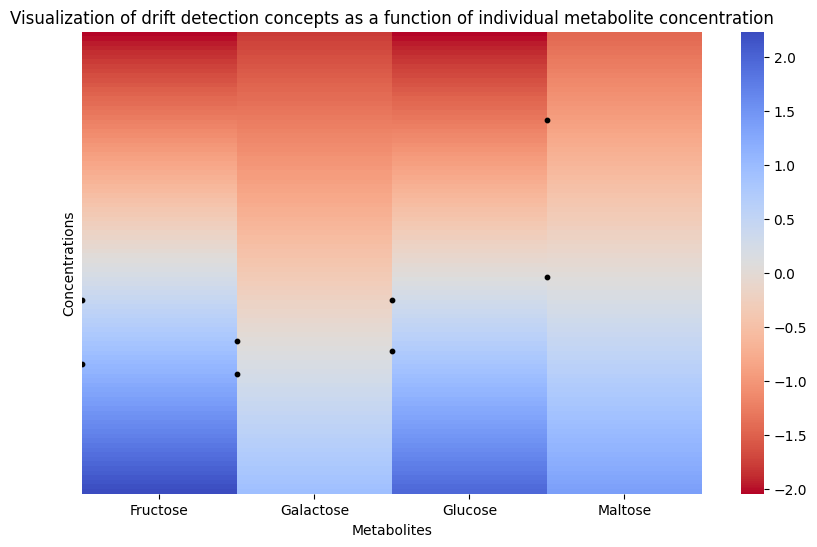

In [76]:
# Data for metabolites and their concentrations (min and max)
metabolites = ['Fructose', 'Galactose', 'Glucose', 'Maltose']
concentrations = [
    [-2.044736304, 2.236747939],  # Fructose
    [-1.777194529, 0.936191154],  # Galactose
    [-2.040773739, 1.961916737],  # Glucose
    [-1.442235377, 1.369442126]   # Maltose
]

# Concentrations you want to mark on the graph
concentrations_to_plot = {
    'Fructose': [0.485030315, 1.069109302],
    'Galactose': [0.065335445, 0.262664307],
    'Glucose': [0.29827073, 0.76120038],
    'Maltose': [-0.895001212, 0.071596568]
}

# Create a matrix between the min and max for each metabolite
matrix = []
for min_val, max_val in concentrations:
    # Create values between min and max (continuous values)
    matrix.append(np.linspace(min_val, max_val, 100))

# Convert to numpy array for the heatmap
matrix = np.array(matrix)

# Create the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(matrix.T, cmap='coolwarm_r', xticklabels=metabolites, yticklabels=False, cbar_kws={})

# Title of the plot
plt.title("Visualization of drift detection concepts as a function of individual metabolite concentration")

# Display concentrations on the graph as lines
for idx, metabolite in enumerate(metabolites):
    for conc in concentrations_to_plot[metabolite]:
        # Find the index of the value on the y-axis
        y_position = np.abs(np.linspace(concentrations[idx][0], concentrations[idx][1], 100) - conc).argmin()
        plt.scatter(idx, y_position, color='black', s=10, zorder=10)

# Show the plot
plt.xlabel("Metabolites")
plt.ylabel("Concentrations")
plt.show()


# Vykreslení subplotů

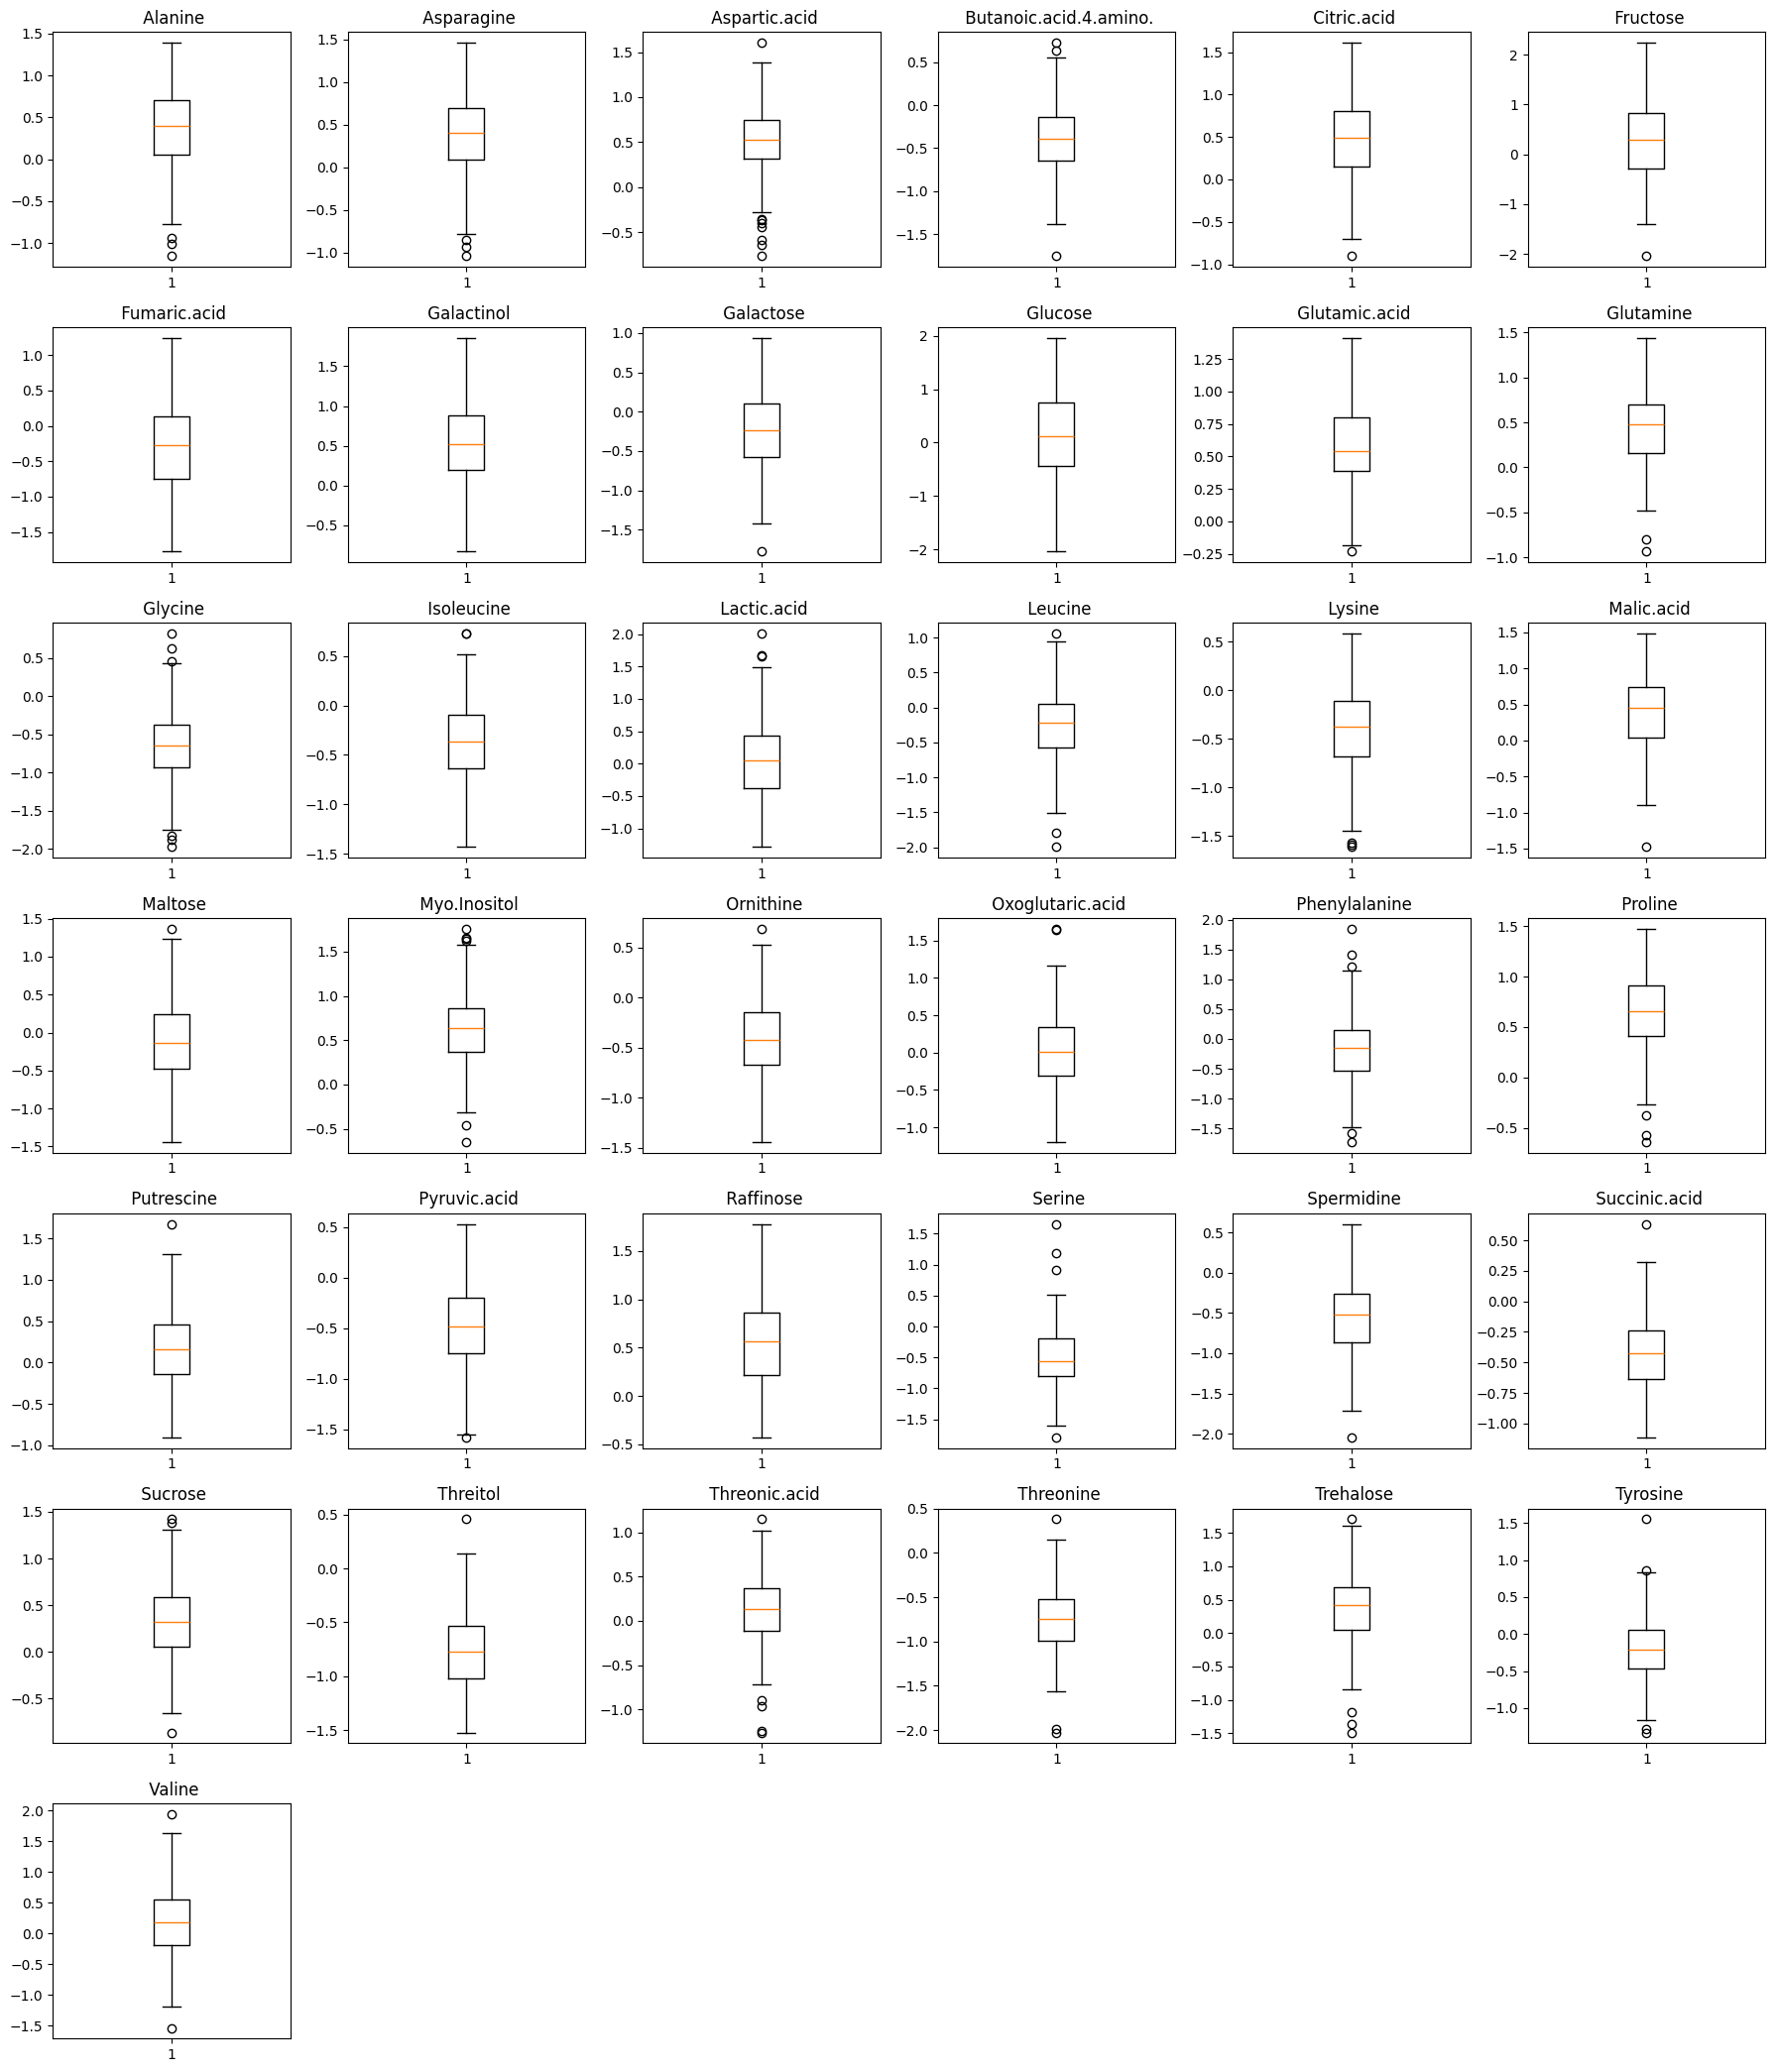

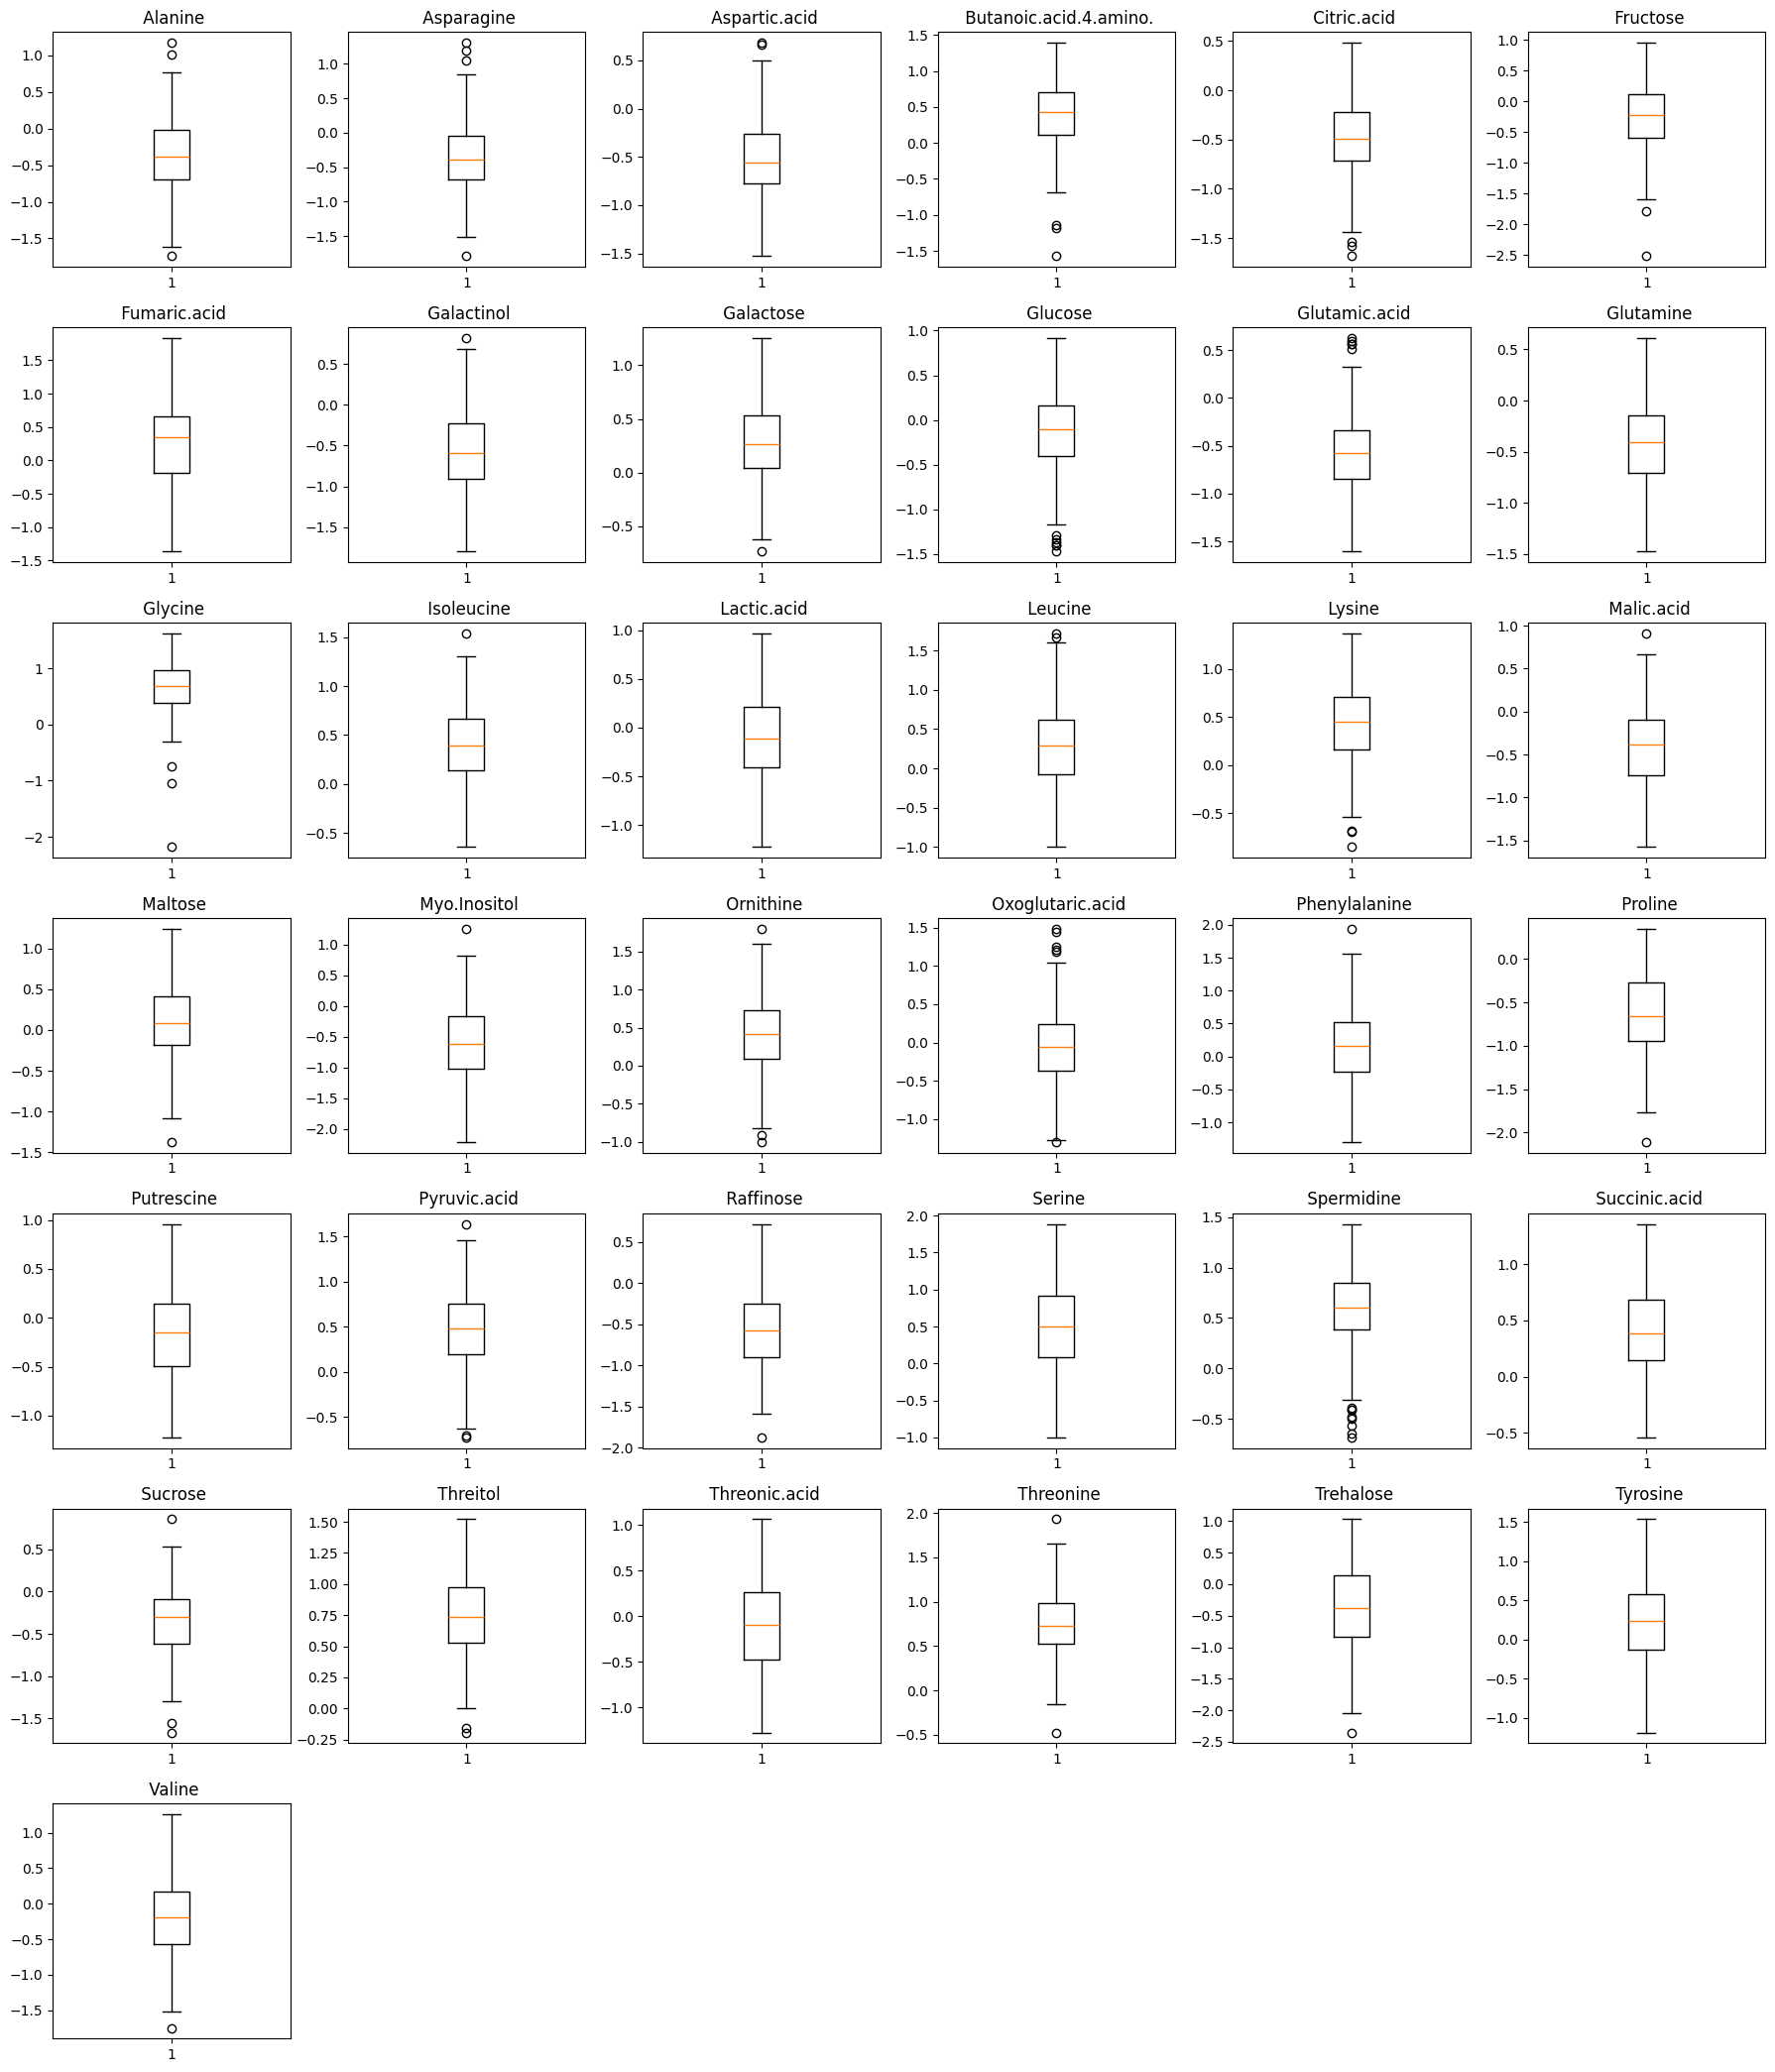

In [35]:
nMetabolites = len(metabolites)
pocet = data_array_6_degree.shape
nRows = pocet[0]
nCols = pocet[1]

### Rozložení subplotů pro 6 °C
cols = 6  # Pevně daný počet sloupců
rows = math.ceil(nMetabolites / cols)  # Automatický výpočet řádků

# Vytvoření figure s daným počtem subgrafů
fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))  # Dynamická velikost

# Kreslení boxplotů
for i in range(nMetabolites):
    row = i // cols  # Index řádku
    col = i % cols   # Index sloupce
    axes[row, col].boxplot(data_array_6_degree[:, i])  # Boxplot pro metabolit i
    axes[row, col].set_title(f' {metabolites[i]}')  # Popisek

# Skrytí nevyužitých subplotů (pokud poslední řádek není plně obsazen)
for i in range(nMetabolites, rows * cols):
    row = i // cols
    col = i % cols
    fig.delaxes(axes[row, col])  # Odstranění prázdných grafů

# Lepší rozložení a zobrazení
plt.tight_layout()
plt.show()

### Rozložení subplotů pro 16 °C
# Vytvoření figure s daným počtem subgrafů
fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))  # Dynamická velikost

# Kreslení boxplotů
for i in range(nMetabolites):
    row = i // cols  # Index řádku
    col = i % cols   # Index sloupce
    axes[row, col].boxplot(data_array_16_degree[:, i])  # Boxplot pro metabolit i
    axes[row, col].set_title(f' {metabolites_16_degree[i]}')  # Popisek


# Skrytí nevyužitých subplotů (pokud poslední řádek není plně obsazen)
for i in range(nMetabolites, rows * cols):
    row = i // cols
    col = i % cols
    fig.delaxes(axes[row, col])  # Odstranění prázdných grafů

# Lepší rozložení a zobrazení
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

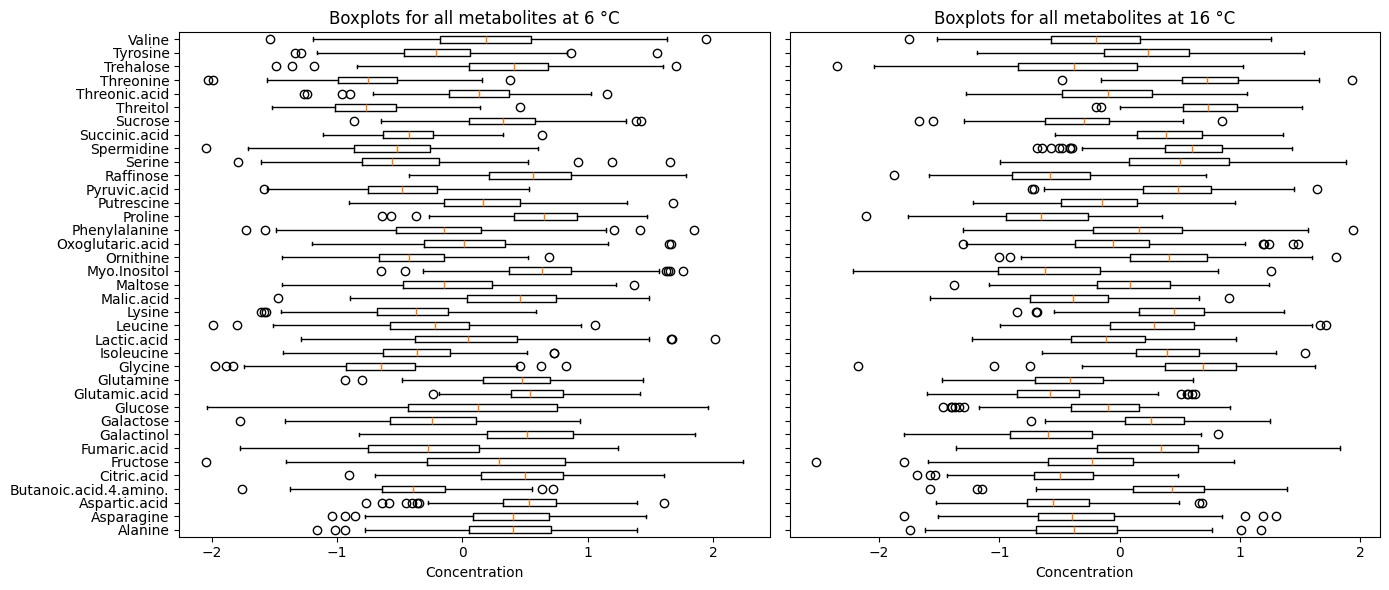

In [17]:
# Vytvoření dvou podgrafů vedle sebe
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)  # 1 řádek, 2 sloupce

# Boxplot pro 6 °C
axes[0].boxplot(data_array_6_degree, vert=False)
axes[0].set_title('Boxplots for all metabolites at 6 °C')
axes[0].set_yticks(range(1, nMetabolites + 1))
axes[0].set_yticklabels(metabolites)
axes[0].set_xlabel('Concentration')

# Boxplot pro 16 °C
axes[1].boxplot(data_array_16_degree, vert=False)
axes[1].set_title('Boxplots for all metabolites at 16 °C')
axes[1].set_yticks(range(1, nMetabolites + 1))
axes[1].set_yticklabels(metabolites_16_degree)
axes[1].set_xlabel('Concentration')

plt.tight_layout()
# Uložení souboru do Colab úložiště
filename = "boxploty_metabolity.tiff"
plt.savefig(filename, dpi=300, bbox_inches='tight', format='tiff')

# Stažení souboru do počítače
files.download(filename)
plt.show()


# EEICT

In [36]:
kf = KFold(n_splits=10, shuffle=True, random_state=42)

X_6_degree = data_33_for_6.copy()
y_6_degree = output_data_array_6_degree.ravel()
X_16_degree = data_33_for_16.copy()
y_16_degree = output_data_array_16_degree.ravel()

X_6_degree_df = pd.DataFrame(X_6_degree)
X_16_degree_df = pd.DataFrame(X_16_degree)

# Pro 6 °C
# If features are different, we align columns by selecting only the common columns
common_columns = X_6_degree_df.columns.intersection(X_16_degree_df.columns)

X_6_degree_common = X_6_degree_df[common_columns]
X_16_degree_common = X_16_degree_df[common_columns]

# Convert back to numpy arrays
X_6_degree_common = X_6_degree_common.to_numpy()
X_16_degree_common = X_16_degree_common.to_numpy()

# Combine the datasets for 6°C and 16°C
X_combined = np.vstack((X_6_degree_common, X_16_degree_common))  # Stack feature matrices
y_combined = np.concatenate((y_6_degree, y_16_degree))  # Concatenate labels

# Model definitions
model_RF = RandomForestRegressor(n_estimators=100, random_state=42)
model_LR = LinearRegression()
model_SVR = SVR(kernel='rbf')
models = {
    "Random Forest Regressor": model_RF,
    "Linear Regression": model_LR,
    "Support Vector Regression": model_SVR
}

# Function to evaluate model
def evaluate_model(model, X, y, cv=10, tolerance=0.01):
    y_pred = cross_val_predict(model, X, y, cv=kf)
    acc = np.mean(np.abs(y - y_pred) / y < tolerance)
    r2 = r2_score(y, y_pred)
    mae = mean_absolute_error(y, y_pred)
    mse = mean_squared_error(y, y_pred)
    rmse = np.sqrt(mse)
    smape = np.mean(2 * np.abs(y - y_pred) / (np.abs(y) + np.abs(y_pred))) * 100

    return [acc, r2, mae, mse, rmse, smape]

# Concept Drift Detection (DDM and EDDM) Functions

def detect_drift_ddm(predictions, classifier_name):
    detect_drift_ddm_idx = []
    ddm = DDM()  # Initialize DDM
    print(f'Concept drift detection, DDM, applied on {classifier_name} classifier:')
    for i, pred in enumerate(predictions):
        ddm.add_element(pred)
        if ddm.detected_warning_zone():
            print(f'Warning zone detected at index: {i}')
        if ddm.detected_change():
            print(f'Change detected at index: {i}')
            detect_drift_ddm_idx.append(i)
    return detect_drift_ddm_idx

def detect_drift_eddm(predictions, classifier_name):
    detect_drift_eddm_idx = []
    eddm = EDDM()  # Initialize EDDM
    print(f'Concept drift detection, EDDM, applied on {classifier_name} classifier:')
    for i, pred in enumerate(predictions):
        eddm.add_element(pred)
        if eddm.detected_warning_zone():
            print(f'Warning zone detected at index: {i}')
        if eddm.detected_change():
            print(f'Change detected at index: {i}')
            detect_drift_eddm.append(i)
    return detect_drift_eddm_idx

# Results for combined data
results_combined = []
detected_drift_indices_combined_ddm = []
detected_drift_indices_combined_eddm = []

for name, model in models.items():
    print(f"\nEvaluating model: {name} on combined data")
    model.fit(X_combined, y_combined)
    results_combined.append([name] + evaluate_model(model, X_combined, y_combined))  # Evaluate on combined dataset
    y_pred_combined = cross_val_predict(model, X_combined, y_combined, cv=kf)  # Get predictions

    drift_ddm_indices_combined = detect_drift_ddm(y_pred_combined, name)  # Detect drift using DDM
    drift_eddm_indices_combined = detect_drift_eddm(y_pred_combined, name)  # Detect drift using EDDM

    detected_drift_indices_combined_ddm.append(drift_ddm_indices_combined)  # Store DDM drift indices
    detected_drift_indices_combined_eddm.append(drift_eddm_indices_combined)  # Store EDDM drift indices

# Print results for combined data
df_results_combined = pd.DataFrame(results_combined, columns=["Model", "Accuracy", "R²", "MAE", "MSE", "RMSE", "SMAPE"])
print("\nResults for Combined Dataset (6°C + 16°C):")
print(df_results_combined)

print("\nDetected drift indices (DDM):")
print(detected_drift_indices_combined_ddm)

print("\nDetected drift indices (EDDM):")
print(detected_drift_indices_combined_eddm)

# Predictions 6°C
print("\nPrediction from 6°C")
results_6 = []
detected_drift_indices_6_ddm = []
detected_drift_indices_6_eddm = []
for name, model in models.items():
    print(f"\nEvaluating model: {name} for 6°C prediction")
    model.fit(X_6_degree, y_6_degree)  # Train on 6°C data
    y_pred_6 = model.predict(X_6_degree)  # Predict on 16°C data
    results_6.append([name] + evaluate_model(model, X_6_degree, y_6_degree))  # Evaluate on 16°C
    drift_ddm_indices_6 = detect_drift_ddm(y_pred_6, name)  # Detect drift using DDM
    drift_eddm_indices_6 = detect_drift_eddm(y_pred_6, name)  # Detect drift using EDDM

    detected_drift_indices_6_ddm.append(drift_ddm_indices_6)  # Store DDM drift indices
    detected_drift_indices_6_eddm.append(drift_eddm_indices_6)  # Store EDDM drift indices


df_results_6 = pd.DataFrame(results_6, columns=["Model", "Accuracy", "R²", "MAE", "MSE", "RMSE", "SMAPE"])
print("\nResults for 6°C Prediction:")
print(df_results_6)

print("\nDetected drift indices (DDM):")
print(detected_drift_indices_6_ddm)

print("\nDetected drift indices (EDDM):")
print(detected_drift_indices_6_eddm)

# Predictions 16°C
print("\nPrediction from 16°C")
detected_drift_indices_16_ddm = []
detected_drift_indices_16_eddm = []
results_16 = []
for name, model in models.items():
    print(f"\nEvaluating model: {name} for 16°C prediction")
    model.fit(X_16_degree, y_16_degree)  # Train on 6°C data
    y_pred_16 = model.predict(X_16_degree)  # Predict on 16°C data
    results_16.append([name] + evaluate_model(model, X_16_degree, y_16_degree))  # Evaluate on 16°C
    drift_ddm_indices_16 = detect_drift_ddm(y_pred_16, name)  # Detect drift using DDM
    drift_eddm_indices_16 = detect_drift_eddm(y_pred_16, name)  # Detect drift using EDDM


    detected_drift_indices_16_ddm.append(drift_ddm_indices_16)  # Store DDM drift indices
    detected_drift_indices_16_eddm.append(drift_eddm_indices_16)  # Store EDDM drift indices

df_results_16 = pd.DataFrame(results_16, columns=["Model", "Accuracy", "R²", "MAE", "MSE", "RMSE", "SMAPE"])
print("\nResults for 16°C Prediction:")
print(df_results_16)

print("\nDetected drift indices (DDM):")
print(detected_drift_indices_16_ddm)

print("\nDetected drift indices (EDDM):")
print(detected_drift_indices_16_eddm)

# Predictions from 6°C to 16°C
print("\nPrediction from 6°C to 16°C")
detected_drift_indices_6_to_16_ddm = []
detected_drift_indices_6_to_16_eddm = []
results_6_to_16 = []
for name, model in models.items():
    print(f"\nEvaluating model: {name} for 6°C → 16°C prediction")
    model.fit(X_6_degree, y_6_degree)  # Train on 6°C data
    y_pred_6_to_16 = model.predict(X_16_degree)  # Predict on 16°C data
    results_6_to_16.append([name] + evaluate_model(model, X_16_degree, y_16_degree))  # Evaluate on 16°C
    drift_ddm_indices_6_to_16 = detect_drift_ddm(y_pred_6_to_16, name)  # Detect drift using DDM
    drift_eddm_indices_6_to_16 =detect_drift_eddm(y_pred_6_to_16, name)  # Detect drift using EDDM

    detected_drift_indices_6_to_16_ddm.append(drift_ddm_indices_6_to_16)  # Store DDM drift indices
    detected_drift_indices_6_to_16_eddm.append(drift_eddm_indices_6_to_16)

df_results_6_to_16 = pd.DataFrame(results_6_to_16, columns=["Model", "Accuracy", "R²", "MAE", "MSE", "RMSE", "SMAPE"])
print("\nResults for 6°C → 16°C Prediction:")
print(df_results_6_to_16)

print("\nDetected drift indices (DDM):")
print(detected_drift_indices_6_to_16_ddm)

print("\nDetected drift indices (EDDM):")
print(detected_drift_indices_6_to_16_eddm)

# Predictions from 16°C to 6°C
print("\nPrediction from 16°C to 6°C")
detected_drift_indices_16_to_6_ddm = []
detected_drift_indices_16_to_6_eddm = []
results_16_to_6 = []
for name, model in models.items():
    print(f"\nEvaluating model: {name} for 16°C → 6°C prediction")
    model.fit(X_16_degree, y_16_degree)  # Train on 16°C data
    y_pred_16_to_6 = model.predict(X_6_degree)  # Predict on 6°C data
    results_16_to_6.append([name] + evaluate_model(model, X_6_degree, y_6_degree))  # Evaluate on 6°C
    drift_ddm_indices_16_to_6 = detect_drift_ddm(y_pred_16_to_6, name)  # Detect drift using DDM
    drift_eddm_indices_16_to_6 = detect_drift_eddm(y_pred_16_to_6, name)  # Detect drift using EDDM

    detected_drift_indices_16_to_6_ddm.append(drift_ddm_indices_16_to_6)  # Store DDM drift indices
    detected_drift_indices_16_to_6_eddm.append(drift_eddm_indices_16_to_6)


df_results_16_to_6 = pd.DataFrame(results_16_to_6, columns=["Model", "Accuracy", "R²", "MAE", "MSE", "RMSE", "SMAPE"])
print("\nResults for 16°C → 6°C Prediction:")
print(df_results_16_to_6)

print("\nDetected drift indices (DDM):")
print(detected_drift_indices_16_to_6_ddm)

print("\nDetected drift indices (EDDM):")
print(detected_drift_indices_16_to_6_eddm)




Evaluating model: Random Forest Regressor on combined data
Concept drift detection, DDM, applied on Random Forest Regressor classifier:
Warning zone detected at index: 274
Warning zone detected at index: 275
Warning zone detected at index: 276
Warning zone detected at index: 277
Warning zone detected at index: 278
Warning zone detected at index: 279
Warning zone detected at index: 280
Warning zone detected at index: 281
Warning zone detected at index: 282
Warning zone detected at index: 283
Warning zone detected at index: 284
Warning zone detected at index: 285
Warning zone detected at index: 286
Warning zone detected at index: 287
Warning zone detected at index: 288
Warning zone detected at index: 289
Warning zone detected at index: 290
Warning zone detected at index: 291
Warning zone detected at index: 292
Warning zone detected at index: 293
Warning zone detected at index: 294
Warning zone detected at index: 295
Warning zone detected at index: 296
Warning zone detected at index: 297

In [19]:
data_4 = np.concatenate((data_4_for_6, data_4_for_16))
ecotype = np.concatenate((ecotypes, ecotypes))
def concentration_suger_ddm(sugar, indices, data, ecotyp):
    for j, name in enumerate(sugar):
        for i in range(len(indices)):
            if indices[i]:
                for idx in indices[i]:
                    if idx > 0:
                        print(f"Koncentrace metabolitu {sugar[j]} na indexu: {indices[i]}, hodnota: {data[i][j]}, ekotyp: {ecotype[i]}")
            else:
                continue
def concentration_suger_eddm(sugar, indices, data, ecotyp):
    for j, name in enumerate(sugar):
        for i in range(len(indices)):
            if indices[i]:
                for idx in indices[i]:
                    if idx > 0:
                        print(f"Koncentrace metabolitu {sugar[j]} na indexu: {indices[i]}, hodnota: {data[i][j]}, ekotyp: {ecotype[i]}")
            else:
                continue

print("\nResults for Combined Dataset (6°C + 16°C):")
print("\nDetected drift indices (DDM):")
concentration_suger_ddm(metabolites_sugar, detected_drift_indices_combined_ddm, data_4, ecotype)
concentration_suger_eddm(metabolites_sugar, detected_drift_indices_combined_eddm, data_4, ecotype)

print("\nResults for 6°C Prediction:")
print("\nDetected drift indices (DDM):")
concentration_suger_ddm(metabolites_sugar, detected_drift_indices_6_ddm, data_4, ecotype)
print("\nDetected drift indices (EDDM):")
concentration_suger_eddm(metabolites_sugar, detected_drift_indices_6_eddm, data_4, ecotype)

print("\nResults for 16°C Prediction:")
print("\nDetected drift indices (DDM):")
concentration_suger_ddm(metabolites_sugar, detected_drift_indices_16_ddm, data_4, ecotype)
print("\nDetected drift indices (EDDM):")
concentration_suger_eddm(metabolites_sugar, detected_drift_indices_16_eddm, data_4, ecotype)

print("\nPrediction from 6°C to 16°C")
print("\nDetected drift indices (DDM):")
concentration_suger_ddm(metabolites_sugar, detected_drift_indices_6_to_16_ddm, data_4, ecotype)
print("\nDetected drift indices (EDDM):")
concentration_suger_eddm(metabolites_sugar, detected_drift_indices_6_to_16_eddm, data_4, ecotype)

print("\nPrediction from 16°C to 6°C")
print("\nDetected drift indices (DDM):")
concentration_suger_ddm(metabolites_sugar, detected_drift_indices_16_to_6_ddm, data_4, ecotype)
print("\nDetected drift indices (EDDM):")
concentration_suger_eddm(metabolites_sugar, detected_drift_indices_16_to_6_eddm, data_4, ecotype)


Results for Combined Dataset (6°C + 16°C):

Detected drift indices (DDM):
Koncentrace metabolitu Fructose na indexu: [324], hodnota: 0.485030315, ekotyp: 6C_410
Koncentrace metabolitu Fructose na indexu: [325], hodnota: 1.069109302, ekotyp: 6C_428
Koncentrace metabolitu Galactose na indexu: [324], hodnota: 0.065335445, ekotyp: 6C_410
Koncentrace metabolitu Galactose na indexu: [325], hodnota: 0.262664307, ekotyp: 6C_428
Koncentrace metabolitu Glucose na indexu: [324], hodnota: 0.29827073, ekotyp: 6C_410
Koncentrace metabolitu Glucose na indexu: [325], hodnota: 0.76120038, ekotyp: 6C_428
Koncentrace metabolitu Maltose na indexu: [324], hodnota: -0.895001212, ekotyp: 6C_410
Koncentrace metabolitu Maltose na indexu: [325], hodnota: 0.071596568, ekotyp: 6C_428

Results for 6°C Prediction:

Detected drift indices (DDM):

Detected drift indices (EDDM):

Results for 16°C Prediction:

Detected drift indices (DDM):

Detected drift indices (EDDM):

Prediction from 6°C to 16°C

Detected drift in